In [8]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
held_in_session_ids = ["MonkeyG_20150925_Session2_S1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [10]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 60])
Test
torch.Size([2500, 20, 60])


In [4]:
# Customize cfg here...
# Now build...

def cfg_base(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.latent_dim = dim
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

cfg.training.epochs = 7001
# cfg.tbfm.training.lambda_ortho = 0.005

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [5]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs)

---- 0 0.7170190811157227 0.7998464107513428 0.47263896465301514 0.5868259072303772
---- 1000 0.4456554055213928 0.6818912625312805 0.5669148564338684 0.6478751301765442
---- 2000 0.3727819621562958 0.6233516335487366 0.6421122550964355 0.6780993342399597
---- 3000 0.3366064727306366 0.6244232058525085 0.681614339351654 0.6772683262825012
---- 4000 0.3075215816497803 0.6086175441741943 0.7151497602462769 0.6855250597000122
---- 5000 0.29694607853889465 0.6078253388404846 0.7279466986656189 0.6859163045883179
---- 6000 0.2871270775794983 0.6102275848388672 0.7390642762184143 0.6846798658370972
---- 7000 0.28444811701774597 0.612079918384552 0.742312490940094 0.6837134957313538
Final: 0.6119822263717651 0.6837643980979919


In [ ]:
# At 7k:
# * Default: 0.6852155327796936
# * lambda_fro = 0.005: 0.6816426515579224
# * lambda_ortho = 0.005: 

In [6]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150925_Session2_S1': 0.6849341988563538}
0.6849341988563538


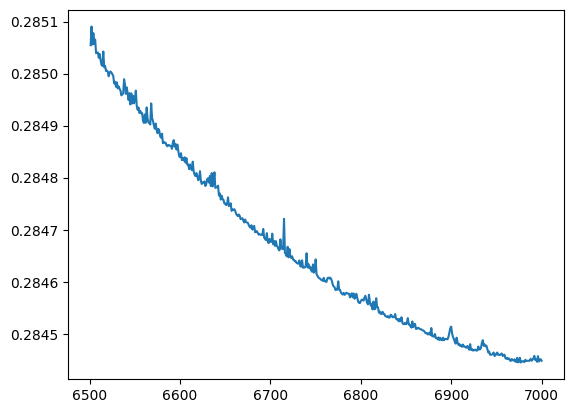

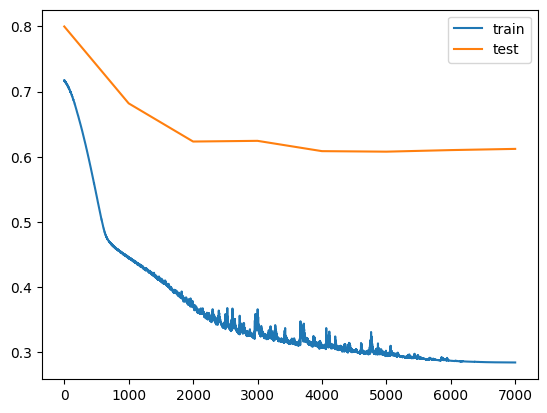

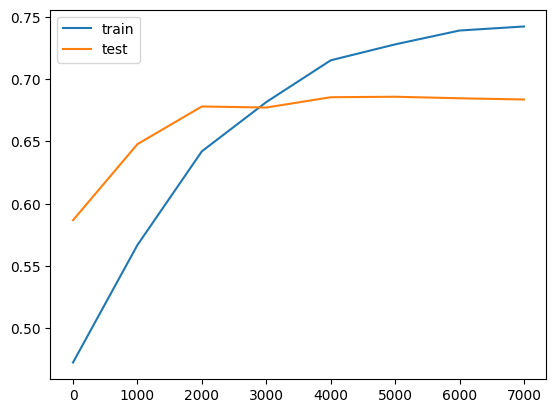

In [6]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [19]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([-0.0614,  0.0382,  0.0541, -0.0395, -0.1412,  0.0947, -0.0753,  0.0451,
         0.0889, -0.0264, -0.0923,  0.0926,  0.0201,  0.0646, -0.2211],
       device='cuda:0')
tensor([-0.0186, -0.1713, -0.0534, -0.1216, -0.0148,  0.0678, -0.0646, -0.0792,
         0.1374, -0.1338,  0.0144, -0.0022, -0.0586, -0.0244,  0.0698],
       device='cuda:0')


In [8]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150917_Session3_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

KeyError: 'MonkeyG_20150917_Session3_S1'

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


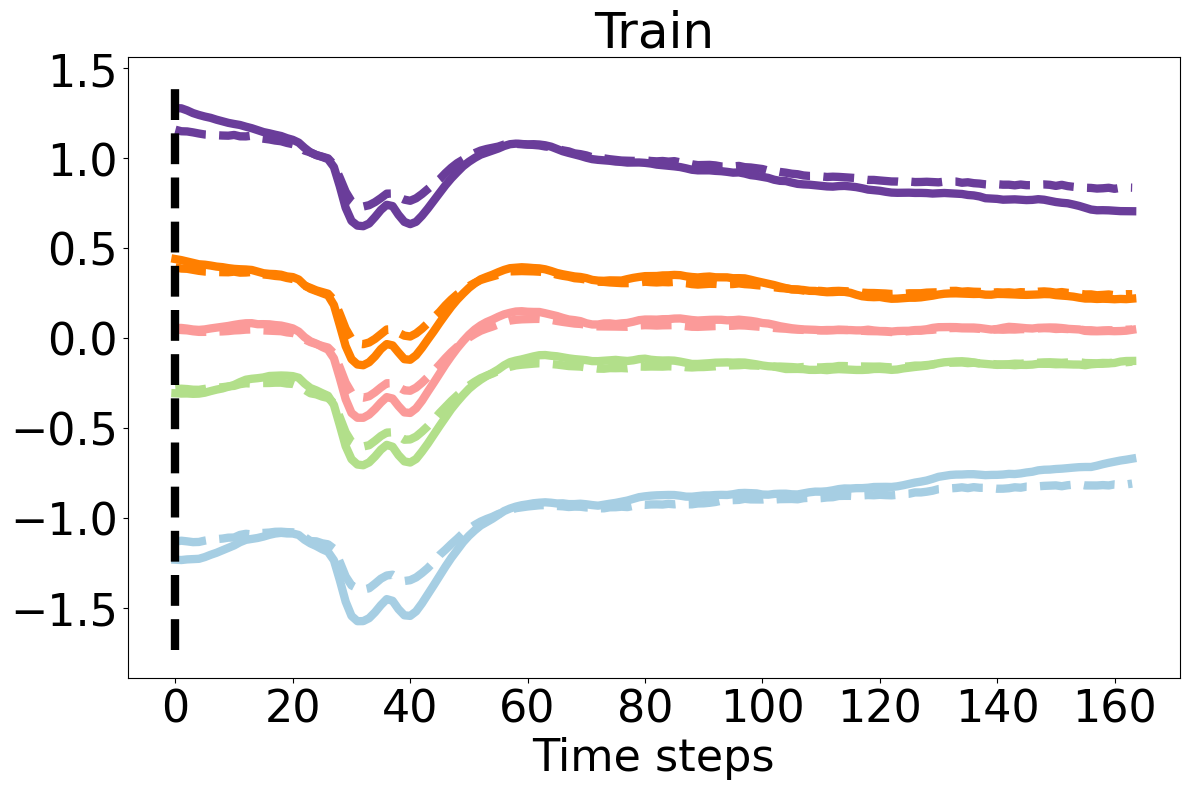

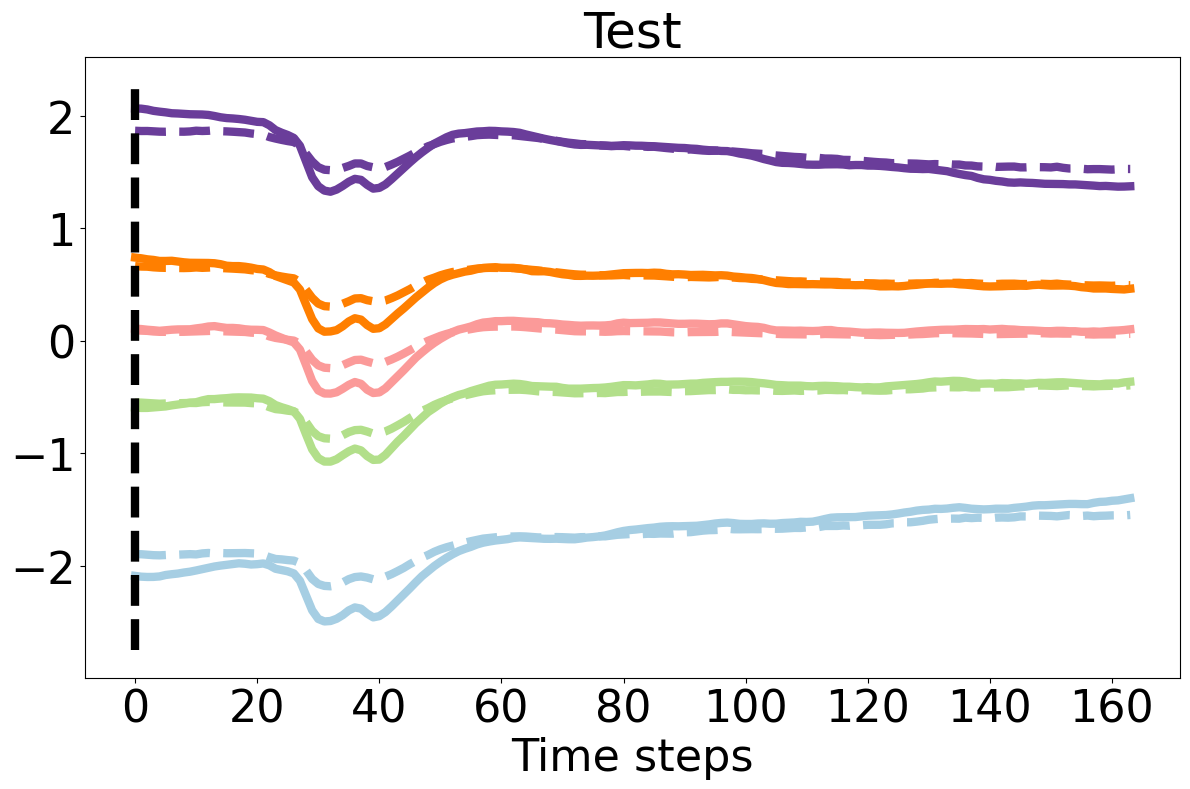

In [7]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=22)

In [33]:
blah = torch.tanh(ms.model.instances[sid].prev_basis_weights[9])
blahs = torch.sum(blah, dim=1)
print(blahs.shape)
print(blahs)

blahn = torch.nn.functional.normalize(blah, p=2, dim=-1)
print(blah.shape, blahn.shape)
print(blahn)

torch.Size([70])
tensor([ 0.3624,  1.3187, -2.8391,  0.9660, -1.0441, -0.9525,  0.7022, -0.0822,
         1.1098,  0.0158,  0.3504, -0.1517, -0.3487, -0.5823, -0.6952, -0.4142,
         0.2541, -1.1497, -1.1219, -0.4731,  0.2360, -0.4768, -0.5137, -0.1212,
        -0.4544, -0.0401, -0.2733,  0.2481, -0.3609, -0.2881, -0.1990,  0.4076,
        -0.9071, -0.5430,  0.4857,  0.7643,  0.5441, -0.1962,  0.1310,  0.2465,
        -1.1134, -0.4256,  0.6031,  0.4499, -1.1188,  0.3667, -0.6012, -0.4048,
         1.4354,  0.5154,  0.7179, -0.1066, -0.6577, -0.3081,  0.0780,  0.5383,
         0.4638,  0.3787, -0.2958,  0.2867, -0.1562, -0.1483,  0.5241,  0.3818,
         0.5556,  0.8531, -0.1996, -0.3095,  0.2297, -0.1108], device='cuda:0',
       grad_fn=<SumBackward1>)
torch.Size([70, 65]) torch.Size([70, 65])
tensor([[-0.1359,  0.1177,  0.0654,  ...,  0.1082, -0.1364, -0.0985],
        [-0.1640,  0.0456,  0.1276,  ...,  0.1349,  0.0088, -0.0881],
        [ 0.2098, -0.1032, -0.1209,  ..., -0.1236,

In [ ]:
# Let's do a test set inference pass so we can look at things.
sid = "MonkeyJ_20160502_Session1_S1"
dt =  utils.move_batch({sid:next(iter(data_train))[sid]}, device=DEVICE)
y_hats = ms(dt)[sid]

print(torch.min(ms.model.instances[sid].prev_basis_weights))
print(torch.max(ms.model.instances[sid].prev_basis_weights))
print(torch.mean(torch.abs(ms.model.instances[sid].prev_basis_weights)))
print(ms.model.instances[sid].prev_basis_weights.shape)

# for cidx in range(70):
#     for idx in range(100):
#         plt.plot(ms.model.instances["MonkeyG_20150925_Session2_S1"].prev_basis_weights[idx, cidx, :].detach().cpu())
#     plt.title(str(cidx))
#     plt.show()

for idx in range(300):
    print(idx, torch.min(ms.model.instances[sid].prev_basis_weights[idx, 0]))

print(ms.model.instances[sid].prev_basis_weights[0, 0, :])
plt.plot(y_hats[0, :, 0].detach().cpu())
plt.plot(dt[sid][2][0, :, 0].detach().cpu(), label="y")
plt.legend()
plt.show()

In [ ]:
# Try:
# cfg.tbfm.module.latent_dim = (16, 32, 64)
# cfg.tbfm.module.embed_dim_stim = (3, 7, 15, 20)

for latent_dim in (16, 32, 64):
    for embed_dim_stim in (3, 7, 15, 20):
        print("---------------", latent_dim, embed_dim_stim)

        # cfg.tbfm.training.lambda_fro = regweight
        # cfg.tbfm.module.num_bases = num_bases
        # cfg.training.grad_clip = grad_clip
        # cfg.latent_dim = latent_dim
        # cfg.tbfm.training.optim.lr_head = lr_head
        # cfg.tbfm.training.lambda_ortho = lambda_ortho
        cfg.tbfm.module.latent_dim = latent_dim
        cfg.tbfm.module.embed_dim_stim = embed_dim_stim
        # cfg.tbfm.module.use_film_bases = True
        # cfg.ae.training.coadapt = True
        cfg.training.epochs = 15001

        ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
        model_optims = multisession.get_optims(cfg, ms)
        
        embeddings_stim, results = multisession.train_from_cfg(
            cfg,
            ms,
            data_train,
            model_optims,
            embeddings_rest,
            data_test=data_test,
            test_interval=5000,
            epochs=cfg.training.epochs,
            )
        torch.save(results, f"res_{latent_dim}_{embed_dim_stim}.torch")

        del model_optims, ms

--------------- 16 3
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1575546264648438 0.9233913421630859 0.0376604589788864 0.062086887657642365
---- 5000 0.5894997715950012 0.5439465641975403 0.4358087678750356 0.44218406081199646
---- 10000 0.5419514775276184 0.5320742130279541 0.48556982477506 0.4532109498977661


In [7]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)


# (0.4636920392513275, './res_2.0_15_0.1.torch')
# (0.463911235332489, './res_7.0_25_0.1.torch')
# (0.4639878273010254, './res_2.0_15_0.01.torch')
# (0.4647655487060547, './res_2.0_20_0.05.torch')
# (0.4657297134399414, './res_7.0_20_0.01.torch')
# (0.4676693379878998, './res_7.0_25_0.05.torch')
# (0.4676762521266937, './res_7.0_15_0.01.torch')
# (0.46845221519470215, './res_2.0_20_0.1.torch')
# (0.4699900150299072, './res_2.0_25_0.01.torch')
# (0.4754122197628021, './res_2.0_20_0.01.torch')

(0.4600786566734314, './res_64_15.torch')
(0.46490734815597534, './res_32_20.torch')
(0.4654322862625122, './res_64_7.torch')
(0.4656924605369568, './res_64_3.torch')
(0.46584925055503845, './res_16_3.torch')
(0.4660493731498718, './res_32_7.torch')
(0.467379093170166, './res_32_3.torch')
(0.46820545196533203, './res_16_7.torch')
(0.4695136547088623, './res_32_15.torch')
(0.4742690324783325, './res_16_15.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}
